### Modeling Optimization Effects Post August 2024 for GDP
- Author: Amanda LaForest
- Date: September 17, 2025
- Most Recent Update: Used Actual Gap Spend Per Their Databricks Systems Tables
- Model: Meta's Prophet Time Series forecasting model
  - **Rationale**: Specifically made for business time-series data, published in 2017, incorporates seasonality and holidays, alternative to traditional ARIMA models

In [0]:
#!pip install prophet

In [0]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# Replace with your table/schema
df = (spark.sql("""
SELECT
  YearMonth,
  -- 5 yr forecast line includes trend line for 1.5% growth rate + 4.6m in planned migrations
  ( ((269258.23+77700)*1.02) * POWER(1.015, (CAST(SUBSTR(YearMonth, 1, 4) AS INTEGER) - 2022) * 12 + (CAST(SUBSTR(YearMonth, 6, 2) AS INTEGER) - 1))) AS five_yr_forecast_line,
  SUM(u.usage_quantity * lp.pricing.default) AS total_list_usd,
  SUM(u.usage_quantity * lp.pricing.default) * 0.58 AS total_gap_usd
FROM (
  SELECT
    date_format(date_trunc('month', u.usage_date), 'yyyy-MM') AS YearMonth,
    u.usage_quantity,
    u.sku_name,
    u.cloud,
    u.usage_unit,
    u.usage_end_time
  FROM system.billing.usage u
) u
LEFT JOIN system.billing.list_prices lp
  ON u.sku_name = lp.sku_name
  AND u.cloud = lp.cloud
  AND u.usage_unit = lp.usage_unit
  AND u.usage_end_time >= lp.price_start_time
  AND (lp.price_end_time IS NULL OR u.usage_end_time < lp.price_end_time)
  AND lp.currency_code = 'USD'
GROUP BY YearMonth
HAVING SUM(u.usage_quantity * lp.pricing.default) * 0.58 >= 600
ORDER BY YearMonth
""").toPandas())

# Prophet needs datetime + float
df["ds"] = pd.to_datetime(df["YearMonth"])
df["y"] = df["total_gap_usd"].astype(float)

# Make sure it's sorted
df = df.sort_values('ds')

In [0]:
df.head(10)

,YearMonth,five_yr_forecast_line,total_list_usd,total_gap_usd,ds,y
0,2023-08,469604.411549,145721.002405,84518.181395,2023-08-01,84518.181395
1,2023-09,476648.477722,879690.560502,510220.525091,2023-09-01,510220.525091
2,2023-10,483798.204888,713782.683054,413993.956171,2023-10-01,413993.956171
3,2023-11,491055.177961,818105.778295,474501.351411,2023-11-01,474501.351411
4,2023-12,498421.005631,810967.778698,470361.311645,2023-12-01,470361.311645
5,2024-01,505897.320715,1151191.552007,667691.100164,2024-01-01,667691.100164
6,2024-02,513485.780526,1314109.384092,762183.442773,2024-02-01,762183.442773
7,2024-03,521188.067234,1312969.599510,761522.367716,2024-03-01,761522.367716
8,2024-04,529005.888242,1151834.361748,668063.929814,2024-04-01,668063.929814
9,2024-05,536940.976566,1325647.065978,768875.298267,2024-05-01,768875.298267


In [0]:
# Monthly series: smooth with a 3-month moving average for model fitting
# NOTE: Filtering on only August 2024 and before for forecasting
df_smooth = df[df['ds']<'2024-08-01'].copy()
df_smooth["y"] = df_smooth["y"].rolling(3, min_periods=1, center=True).mean()

# Cap extreme spikes (winsorize at 1st/99th percentile)
q1, q99 = df_smooth["y"].quantile([0.01, 0.99])
df_smooth["y"] = df_smooth["y"].clip(q1, q99)

m = Prophet(
    yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
    growth="linear",
    seasonality_mode="multiplicative",     # try "additive" if level is stable
    changepoint_prior_scale=0.01,          # ↓ smoother trend
    seasonality_prior_scale=.1,           # ↓ gentler seasonality
    n_changepoints=10,                     # fewer kinks
    changepoint_range=0.8,                 # don't overfit the last tail
    #uncertainty_samples=0                  # deterministic forecast line
)
m.fit(df_smooth)  # df has columns ds (datetime) and y (float)

future = m.make_future_dataframe(periods=12, freq="MS")
forecast = m.predict(future)

20:20:37 - cmdstanpy - INFO - Chain [1] start processing
20:20:38 - cmdstanpy - INFO - Chain [1] done processing


In [0]:
display(forecast)

ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
2023-08-01T00:00:00.000Z,329024.24115514604,301645.86164812685,301645.86200575763,329024.24115514604,329024.24115514604,-0.08321082735898963,-0.08321082735898963,-0.08321082735898963,-0.08321082735898963,-0.08321082735898963,-0.08321082735898963,0.0,0.0,0.0,301645.8618274626
2023-09-01T00:00:00.000Z,378749.53587296145,336244.4631110613,336244.46345041937,378749.53587296145,378749.53587296145,-0.11222475161865565,-0.11222475161865565,-0.11222475161865565,-0.11222475161865565,-0.11222475161865565,-0.11222475161865565,0.0,0.0,0.0,336244.46328393725
2023-10-01T00:00:00.000Z,426870.7887278313,466238.78079887544,466238.7811340539,426870.7887278313,426870.7887278313,0.09222461051838263,0.09222461051838263,0.09222461051838263,0.09222461051838263,0.09222461051838263,0.09222461051838263,0.0,0.0,0.0,466238.78095993033
2023-11-01T00:00:00.000Z,476596.08401307196,452952.35195724596,452952.3523085541,476596.08401307196,476596.08401307196,-0.04960958069153047,-0.04960958069153047,-0.04960958069153047,-0.04960958069153047,-0.04960958069153047,-0.04960958069153047,0.0,0.0,0.0,452952.3521259581
2023-12-01T00:00:00.000Z,524717.3384758529,537517.9858258567,537517.9861771716,524717.3384758529,524717.3384758529,0.02439532027086251,0.02439532027086251,0.02439532027086251,0.02439532027086251,0.02439532027086251,0.02439532027086251,0.0,0.0,0.0,537517.9859996458
2024-01-01T00:00:00.000Z,574442.6366483269,633411.9550063834,633411.9553333587,574442.6366483269,574442.6366483269,0.10265484273214641,0.10265484273214641,0.10265484273214641,0.10265484273214641,0.10265484273214641,0.10265484273214641,0.0,0.0,0.0,633411.9551721003
2024-02-01T00:00:00.000Z,624167.9349216977,730465.5563430808,730465.5566851588,624167.9349216977,624167.9349216977,0.1703029195281893,0.1703029195281893,0.1703029195281893,0.1703029195281893,0.1703029195281893,0.1703029195281893,0.0,0.0,0.0,730465.5565147437
2024-03-01T00:00:00.000Z,670685.1500117829,730589.9511309915,730589.9514705936,670685.1500117829,670685.1500117829,0.08931881269072225,0.08931881269072225,0.08931881269072225,0.08931881269072225,0.08931881269072225,0.08931881269072225,0.0,0.0,0.0,730589.9513001343
2024-04-01T00:00:00.000Z,720410.4489566111,732820.5694662797,732820.5697852795,720410.4489566111,720410.4489566111,0.0172264584542762,0.0172264584542762,0.0172264584542762,0.0172264584542762,0.0172264584542762,0.0172264584542762,0.0,0.0,0.0,732820.5696255887
2024-05-01T00:00:00.000Z,768531.7061811778,737896.6342943386,737896.6346183859,768531.7061811778,768531.7061811778,-0.039861818958175886,-0.039861818958175886,-0.039861818958175886,-0.039861818958175886,-0.039861818958175886,-0.039861818958175886,0.0,0.0,0.0,737896.6344457656


In [0]:
# Calculate difference between actual and forecast
df['yhat'] = forecast['yhat']
df['difference'] = df['y'] - forecast['yhat']

# Filter before Oct 2025
#df = df[df['ds']<'2025-10-01']

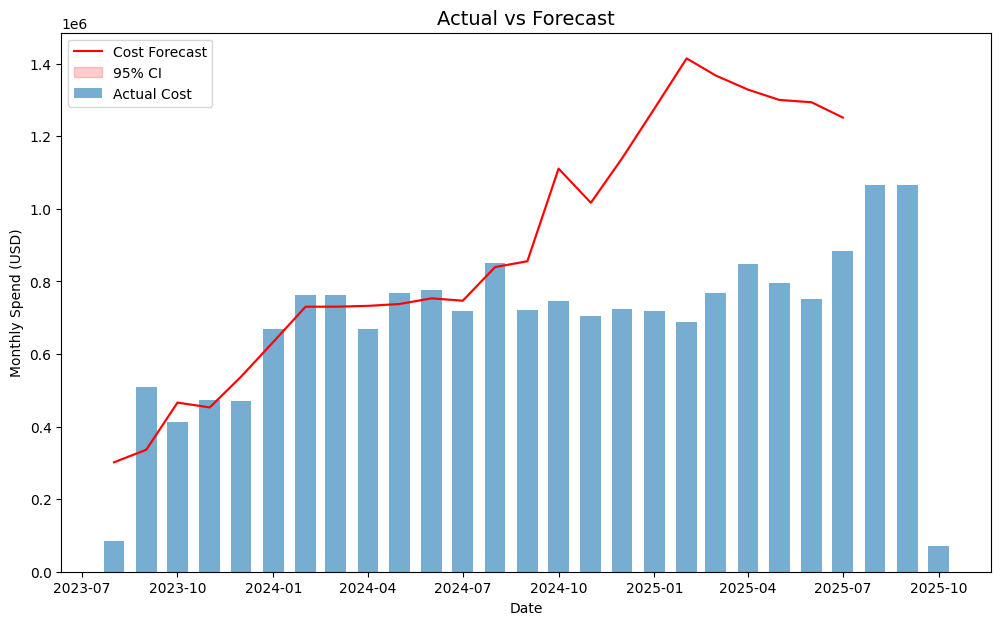

In [0]:
# df = your original data with ds (datetime) and y (numeric)
# forecast = Prophet output with ds, yhat, yhat_lower, yhat_upper

fig, ax = plt.subplots(figsize=(12,7)) 

# 1) Original data as bar chart
ax.bar(df["ds"], df["y"], width=20, alpha=0.6, label="Actual Cost")

# 2) Forecast as line
ax.plot(forecast["ds"], forecast["yhat"], color="red", label="Cost Forecast")

# 3) Confidence interval (optional)
ax.fill_between(forecast["ds"],
                forecast["yhat_lower"],
                forecast["yhat_upper"],
                color="red", alpha=0.2, label="95% CI")

# 4) Styling
ax.set_title("Actual vs Forecast", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Monthly Spend (USD)")
ax.legend(loc="upper left")

plt.show()

In [0]:
print('PRE OPTIMIZATION')

# Average Actual vs. Expected 6 months prior to intervention (optimization)
print('9 Months Pre-Intervention:', round(df[(df['ds']<'2024-09-01') & (df['ds']>='2023-12-01')]['difference'].mean(),2),'spent per month OVER predicted based on forecasting model (Meta Prophet)\n')

print('POST OPTIMIZATION')

# Average Actual vs. Expected 6 months post-intervention
print('9 Months Post-Intervention', round(df[(df['ds']>='2024-09-01') & (df['ds']>='2023-12-01')]['difference'].mean(),2),'spent per month UNDER predicted based on forecasting model (Meta Prophet)')

print('9 Months Post-Intervention', abs(round(df[(df['ds']>='2024-09-01') & (df['ds']<='2025-05-01')]['difference'].sum(),2)),'estimated total savings')

PRE OPTIMIZATION
9 Months Pre-Intervention: 44.45 spent per month OVER predicted based on forecasting model (Meta Prophet)

POST OPTIMIZATION
9 Months Post-Intervention -455056.35 spent per month UNDER predicted based on forecasting model (Meta Prophet)
9 Months Post-Intervention 4095642.13 estimated total savings


In [0]:
df[(df['ds']<'2024-09-01') & (df['ds']>='2023-12-01')].reset_index()

,index,YearMonth,five_yr_forecast_line,total_list_usd,total_gap_usd,ds,y,yhat,difference
0,4,2023-12,498421.005631,810967.778698,470361.311645,2023-12-01,470361.311645,537517.986000,-67156.674355
1,5,2024-01,505897.320715,1151191.552007,667691.100164,2024-01-01,667691.100164,633411.955172,34279.144992
2,6,2024-02,513485.780526,1314109.384092,762183.442773,2024-02-01,762183.442773,730465.556515,31717.886258
3,7,2024-03,521188.067234,1312969.599510,761522.367716,2024-03-01,761522.367716,730589.951300,30932.416416
4,8,2024-04,529005.888242,1151834.361748,668063.929814,2024-04-01,668063.929814,732820.569626,-64756.639812
5,9,2024-05,536940.976566,1325647.065978,768875.298267,2024-05-01,768875.298267,737896.634446,30978.663821
6,10,2024-06,544995.091214,1339223.901579,776749.862916,2024-06-01,776749.862916,753521.345931,23228.516985
7,11,2024-07,553170.017583,1236792.323699,717339.547745,2024-07-01,717339.547745,747044.994468,-29705.446723
8,12,2024-08,561467.567846,1466563.929475,850607.079096,2024-08-01,850607.079096,839724.885673,10882.193423


In [0]:
df[(df['ds']>='2024-09-01') & (df['ds']<='2025-05-01')].reset_index()

,index,YearMonth,five_yr_forecast_line,total_list_usd,total_gap_usd,ds,y,yhat,difference
0,13,2024-09,569889.581364,1244274.664891,721679.305637,2024-09-01,721679.305637,8.557448e+05,-134065.475854
1,14,2024-10,578437.925084,1285213.897353,745424.060465,2024-10-01,745424.060465,1.111021e+06,-365596.444476
2,15,2024-11,587114.493961,1215801.875164,705165.087595,2024-11-01,705165.087595,1.016917e+06,-311752.393370
3,16,2024-12,595921.211370,1246821.389040,723156.405643,2024-12-01,723156.405643,1.139517e+06,-416360.665505
4,17,2025-01,604860.029541,1237389.125958,717685.693056,2025-01-01,717685.693056,1.276352e+06,-558666.464736
5,18,2025-02,613932.929984,1186785.442266,688335.556514,2025-02-01,688335.556514,1.414771e+06,-726435.834103
6,19,2025-03,623141.923933,1323463.305109,767608.716963,2025-03-01,767608.716963,1.367590e+06,-599980.916860
7,20,2025-04,632489.052792,1464285.237443,849285.437717,2025-04-01,849285.437717,1.328674e+06,-479388.401717
8,21,2025-05,641976.388584,1374160.471584,797013.073519,2025-05-01,797013.073519,1.300409e+06,-503395.535818


In [0]:
spark_df = spark.createDataFrame(df)
spark_df.write.mode("overwrite").saveAsTable("main.billing_forecast_demo.aug_2024_optimization_results")